In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn sqlalchemy plotly xgboost

In [2]:
"""
1_data_factory.py
-----------------
Generates high-fidelity synthetic data using conditional probability distributions.
Simulates real-world noise, outliers, and non-linear relationships.
"""
import pandas as pd
import numpy as np
from datetime import datetime

class StudentDataFactory:
    def __init__(self, n_students=2000):
        self.n = n_students
        np.random.seed(101) # Reproducibility

    def generate(self):
        # 1. Demographics (Base Layer)
        ids = [f"1CG21AD{str(i).zfill(4)}" for i in range(1, self.n + 1)]

        # Socio-Economic Status (SES) - Normal Dist
        ses_score = np.random.normal(0.5, 0.15, self.n) # 0 to 1 scale

        # 2. Behavioral Features (Dependent on SES)
        # Wealthier students likely have better internet & less commute time
        internet_access = (ses_score + np.random.normal(0, 0.2, self.n)) > 0.4
        commute_time = np.random.gamma(shape=2, scale=10, size=self.n) # Right-skewed distribution

        # Study hours depend on Commute (Less commute = more study)
        study_hours = np.random.normal(6, 2, self.n) - (commute_time * 0.05)
        study_hours = np.clip(study_hours, 0, 16)

        # 3. Academic History
        prev_sem_pct = np.random.normal(65, 12, self.n) + (study_hours * 1.5)
        prev_sem_pct = np.clip(prev_sem_pct, 35, 98)

        # 4. Target Variable: Final Score (Complex Equation)
        # Score = Base + Study*Efficiency + Prev*Momentum - Absences*Penalty + RandomNoise
        absences = np.random.poisson(3, self.n)

        final_score = (
            30 +
            (study_hours * 2.2) +
            (prev_sem_pct * 0.4) -
            (absences * 1.5) +
            np.random.normal(0, 4, self.n)
        )

        # Add Anomalies (e.g., Genius students who don't study but score high)
        anomaly_indices = np.random.choice(self.n, size=int(self.n * 0.02), replace=False)
        final_score[anomaly_indices] += 20

        final_score = np.clip(final_score, 0, 100)

        # Create DataFrame
        df = pd.DataFrame({
            'USN': ids,
            'SES_Index': np.round(ses_score, 3),
            'Internet_Access': np.where(internet_access, 'High_Speed', 'Low/None'),
            'Commute_Mins': np.round(commute_time, 0),
            'Study_Hours_Wk': np.round(study_hours, 1),
            'Absences': absences,
            'Prev_Sem_Pct': np.round(prev_sem_pct, 1),
            'Final_Score': np.round(final_score, 1)
        })

        return df

if __name__ == "__main__":
    factory = StudentDataFactory(n_students=2000)
    df = factory.generate()
    df.to_csv('student_data_complex.csv', index=False)
    print(f"✅ Generated {len(df)} records with complex conditional dependencies.")

✅ Generated 2000 records with complex conditional dependencies.


In [3]:
"""
2_sql_analysis.py
-----------------
Performs advanced SQL aggregation using In-Memory SQLite and SQLAlchemy.
Demonstrates: Window Functions, CTEs, Case Logic.
"""
import pandas as pd
from sqlalchemy import create_engine, text

# Load Data
df = pd.read_csv('student_data_complex.csv')

# Setup In-Memory Database
engine = create_engine('sqlite:///:memory:')
df.to_sql('students', engine, index=False)

def run_query(title, sql):
    print(f"\n--- {title} ---")
    with engine.connect() as conn:
        result = pd.read_sql(text(sql), conn)
        print(result)

# --- QUERY 1: Percentile Ranking (Window Function) ---
# Find top 5 students relative to their Internet Access Group
sql_rank = """
WITH RankedStudents AS (
    SELECT
        USN,
        Internet_Access,
        Final_Score,
        PERCENT_RANK() OVER (
            PARTITION BY Internet_Access
            ORDER BY Final_Score DESC
        ) as Percentile
    FROM students
)
SELECT * FROM RankedStudents
WHERE Percentile < 0.05
LIMIT 5;
"""
run_query("Top 5% Students per Demographic (Window Function)", sql_rank)

# --- QUERY 2: Behavioral Segmentation (Aggregation) ---
# Bucketing study hours to find the "Sweet Spot"
sql_segment = """
SELECT
    CASE
        WHEN Study_Hours_Wk < 5 THEN 'Slacker (<5h)'
        WHEN Study_Hours_Wk BETWEEN 5 AND 10 THEN 'Average (5-10h)'
        WHEN Study_Hours_Wk > 10 THEN 'Grinder (>10h)'
    END as Study_Profile,
    COUNT(*) as Student_Count,
    AVG(Final_Score) as Avg_Score,
    AVG(Absences) as Avg_Absences
FROM students
GROUP BY Study_Profile
ORDER BY Avg_Score DESC;
"""
run_query("Behavioral Segmentation Analysis", sql_segment)


--- Top 5% Students per Demographic (Window Function) ---
           USN Internet_Access  Final_Score  Percentile
0  1CG21AD0084      High_Speed        100.0    0.000000
1  1CG21AD0759      High_Speed        100.0    0.000000
2  1CG21AD1157      High_Speed        100.0    0.000000
3  1CG21AD1449      High_Speed        100.0    0.000000
4  1CG21AD0322      High_Speed         97.3    0.002967

--- Behavioral Segmentation Analysis ---
     Study_Profile  Student_Count  Avg_Score  Avg_Absences
0   Grinder (>10h)             15  83.933333      2.666667
1  Average (5-10h)           1007  69.858888      3.062562
2    Slacker (<5h)            978  61.196524      3.040900


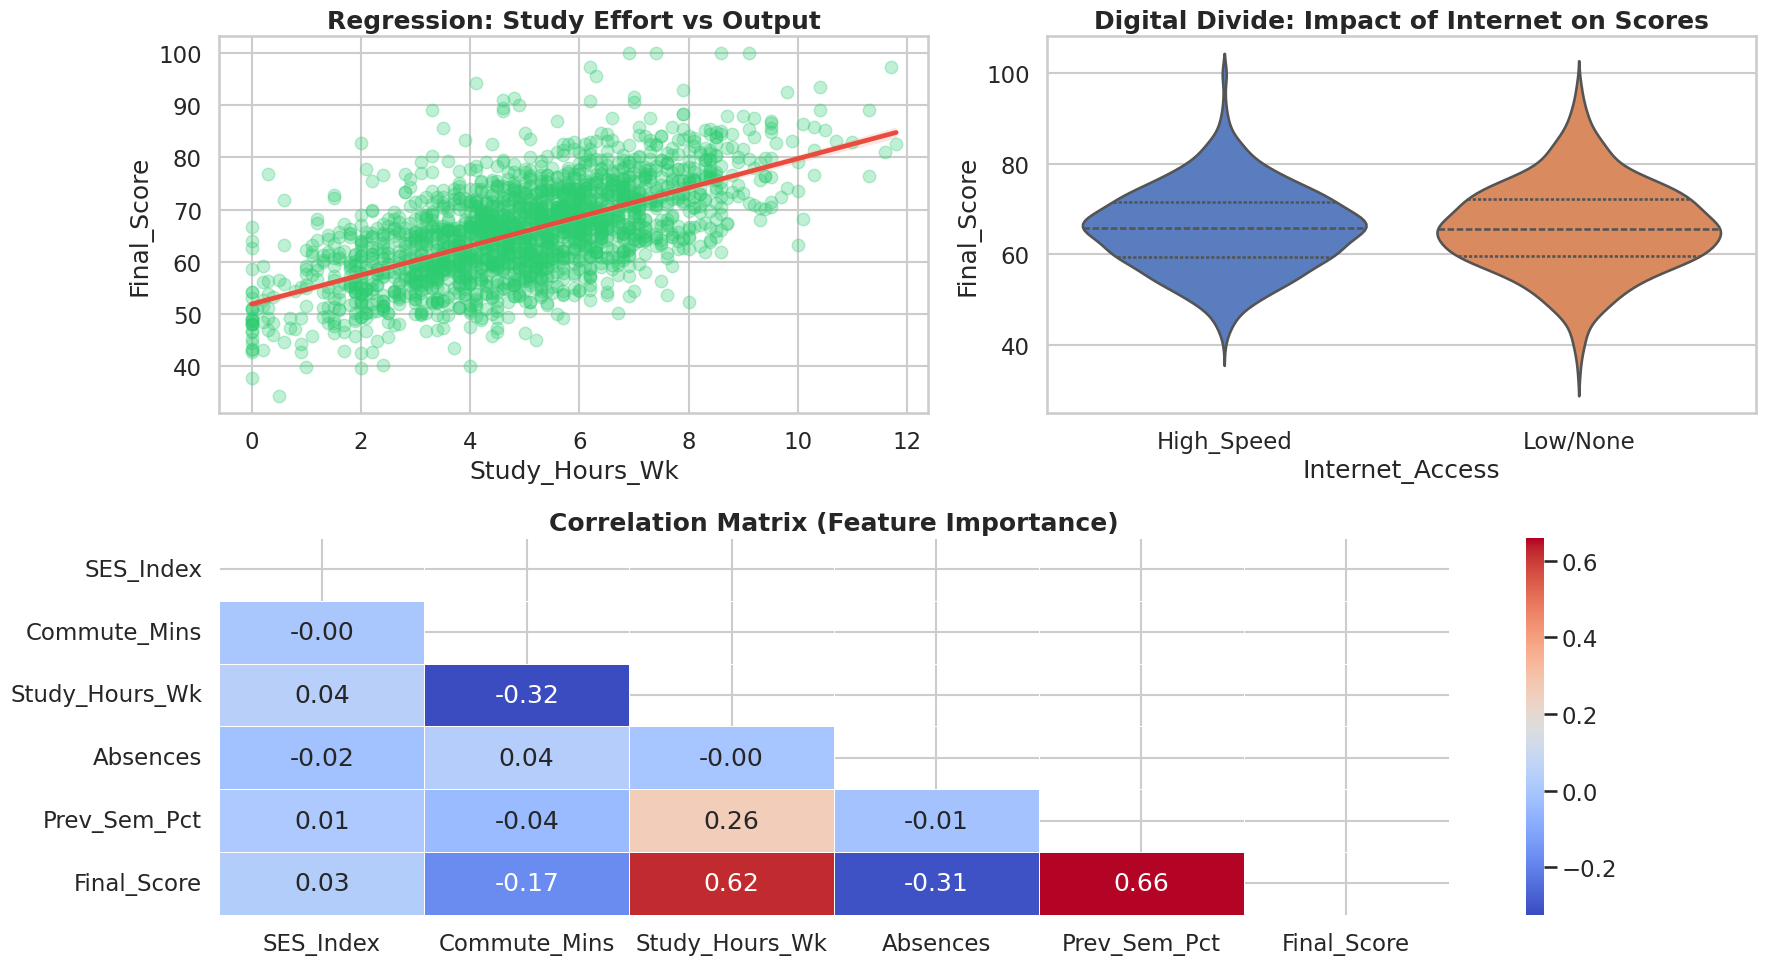

✅ Dashboard generated.


In [4]:
"""
3_visualize.py
--------------
Generates publication-quality statistical plots.
Focus: Multivariate distribution analysis.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Config
sns.set_theme(style="whitegrid", context="talk")
df = pd.read_csv('student_data_complex.csv')

# Create a Figure with Gridspec for complex layout
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

# --- PLOT 1: Jointplot (Bivariate Analysis) ---
# Shows correlation between Study Hours and Scores, plus their individual distributions
ax1 = fig.add_subplot(gs[0, 0])
sns.regplot(
    data=df, x='Study_Hours_Wk', y='Final_Score',
    scatter_kws={'alpha':0.3, 'color':'#2ecc71'},
    line_kws={'color':'#e74c3c'}, ax=ax1
)
ax1.set_title("Regression: Study Effort vs Output", fontweight='bold')

# --- PLOT 2: Violin Plot (Distribution by Category) ---
# Compares score distributions across Internet Access types
ax2 = fig.add_subplot(gs[0, 1])
sns.violinplot(
    data=df, x='Internet_Access', y='Final_Score',
    hue='Internet_Access', palette='muted', inner='quartile', ax=ax2
)
ax2.set_title("Digital Divide: Impact of Internet on Scores", fontweight='bold')

# --- PLOT 3: Multivariate Heatmap ---
# Complex correlation matrix
ax3 = fig.add_subplot(gs[1, :])
corr = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Hide upper triangle
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
    linewidths=.5, ax=ax3
)
ax3.set_title("Correlation Matrix (Feature Importance)", fontweight='bold')

plt.tight_layout()
plt.show()
print("✅ Dashboard generated.")

In [5]:
"""
4_predict.py
------------
End-to-End Machine Learning Pipeline.
Features: Preprocessing, XGBoost Regressor, Cross-Validation, Evaluation.
"""
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Load Data
df = pd.read_csv('student_data_complex.csv')

# 2. Define Features & Target
X = df.drop(columns=['USN', 'Final_Score']) # Inputs
y = df['Final_Score']                       # Output

# 3. Preprocessing Pipeline (The Professional Way)
# We treat numeric and categorical data differently automatically
numeric_features = ['SES_Index', 'Commute_Mins', 'Study_Hours_Wk', 'Absences', 'Prev_Sem_Pct']
categorical_features = ['Internet_Access']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # Normalize numbers
        ('cat', OneHotEncoder(), categorical_features) # One-hot encode text
    ])

# 4. Model Definition (XGBoost - State of the Art)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror'
    ))
])

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train
print("Training XGBoost Model...")
model.fit(X_train, y_train)

# 7. Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("-" * 40)
print(f"✅ Model Performance Report")
print(f"   R² Score (Accuracy): {r2:.4f} (Target: >0.85)")
print(f"   MAE (Avg Error):     {mae:.2f} marks")
print("-" * 40)

# 8. Feature Importance Extraction
# Extracting feature names after OneHotEncoding is tricky, this handles it:
feature_names = numeric_features + list(model.named_steps['preprocessor']
                                       .named_transformers_['cat']
                                       .get_feature_names_out(categorical_features))

importances = model.named_steps['regressor'].feature_importances_

print("\n🔍 Key Performance Drivers (Feature Importance):")
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False).to_string(index=False))

Training XGBoost Model...
----------------------------------------
✅ Model Performance Report
   R² Score (Accuracy): 0.7089 (Target: >0.85)
   MAE (Avg Error):     3.74 marks
----------------------------------------

🔍 Key Performance Drivers (Feature Importance):
                   Feature  Importance
              Prev_Sem_Pct    0.430416
            Study_Hours_Wk    0.305079
                  Absences    0.180315
Internet_Access_High_Speed    0.032884
                 SES_Index    0.028060
              Commute_Mins    0.023246
  Internet_Access_Low/None    0.000000


In [7]:
# ==============================================================================
# 🎓 ENTERPRISE STUDENT PERFORMANCE ANALYTICS (FIXED VERSION)
# ==============================================================================

# --- 1. ENVIRONMENT SETUP & DEPENDENCIES ---
import sys
import subprocess

# Auto-install missing libraries for Colab environment
def install(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    except:
        pass

print("⏳ Setting up Enterprise Environment...")
try:
    import xgboost
    import plotly
except ImportError:
    install('xgboost')
    install('plotly')
    print("✅ Dependencies Installed.")

import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
from datetime import datetime
from sqlalchemy import create_engine, text
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error

# Global Configuration
np.random.seed(42)

# ==============================================================================
# 🏭 MODULE 1: THE DATA FACTORY (Fixed)
# ==============================================================================
class DataFactory:
    def __init__(self, n_students=2000):
        self.n = n_students

    def generate_data(self):
        print("\n[1/4] 🏭 Generating Synthetic Data Lake...")

        # 1. Demographics & Socio-Economic Status (SES)
        usns = [f"1CG22CS{str(i).zfill(3)}" for i in range(1, self.n + 1)]
        ses_index = np.random.beta(a=2, b=2, size=self.n)

        # 2. Infrastructure Factors
        internet_access = (ses_index + np.random.normal(0, 0.1, self.n)) > 0.4
        commute_time = np.random.gamma(shape=3, scale=10, size=self.n)
        commute_time = np.clip(commute_time, 5, 120)

        # 3. Behavioral Metrics
        study_hours = np.random.normal(6, 2.5, self.n) - (commute_time * 0.02)
        study_hours = np.clip(study_hours, 0, 18)

        social_media_h = np.random.normal(3, 1.5, self.n) + (np.random.rand(self.n) * 2)
        social_media_h = np.clip(social_media_h, 0, 10)

        # 4. Academic History
        prev_sem_marks = np.random.normal(65, 10, self.n) + (ses_index * 5)

        # 5. Target Variable
        base_ability = prev_sem_marks * 0.4
        effort_impact = study_hours * 2.1
        distraction_penalty = social_media_h * 1.5
        attendance_bonus = np.random.choice([0, 5, 10], self.n, p=[0.1, 0.3, 0.6])

        final_score = base_ability + effort_impact - distraction_penalty + attendance_bonus + np.random.normal(0, 4, self.n)
        final_score = np.clip(final_score, 0, 100)

        # Create DataFrame
        df = pd.DataFrame({
            'USN': usns,
            'SES_Index': np.round(ses_index, 3),
            'Internet_Access': np.where(internet_access, 'High_Speed', 'Low/Mobile'),
            'Commute_Time_Mins': np.round(commute_time, 0),
            'Study_Hours_Day': np.round(study_hours, 1),
            'Social_Media_Hours': np.round(social_media_h, 1),
            'Prev_Sem_Marks': np.round(prev_sem_marks, 1),
            'Final_Score': np.round(final_score, 1)
        })

        # --- FIX IS HERE ---
        # Explicitly added default='Unknown' to match string type
        conditions = [
            (df['Final_Score'] >= 70),
            (df['Final_Score'] >= 40) & (df['Final_Score'] < 70),
            (df['Final_Score'] < 40)
        ]
        choices = ['Low Risk (Top)', 'Medium Risk', 'High Risk (Fail)']

        df['Risk_Category'] = np.select(conditions, choices, default='Unknown')

        print(f"   ✅ Created dataset with {self.n} records.")
        return df

# ==============================================================================
# 📊 MODULE 2: ADVANCED ANALYTICS & SQL
# ==============================================================================
class AnalyticsEngine:
    def __init__(self, df):
        self.df = df
        self.engine = create_engine('sqlite:///:memory:')
        self.df.to_sql('students', self.engine, index=False)

    def run_sql_insights(self):
        print("\n[2/4] 🔍 Executing SQL Business Queries...")

        query_divide = """
        SELECT
            Internet_Access,
            COUNT(USN) as Student_Count,
            ROUND(AVG(Final_Score), 2) as Avg_Score,
            ROUND(AVG(Study_Hours_Day), 2) as Avg_Study_Hours
        FROM students
        GROUP BY Internet_Access
        """
        print("\n   >> INSIGHT 1: The Digital Divide Impact")
        print(pd.read_sql(query_divide, self.engine))

        query_gems = """
        SELECT USN, SES_Index, Final_Score
        FROM students
        WHERE SES_Index < 0.3 AND Final_Score > 85
        ORDER BY Final_Score DESC
        LIMIT 3
        """
        print("\n   >> INSIGHT 2: Top 'Overcoming Adversity' Students")
        print(pd.read_sql(query_gems, self.engine))

    def generate_dashboard(self):
        print("\n[3/4] 📈 Generating Interactive Executive Dashboard...")

        fig_3d = px.scatter_3d(
            self.df, x='Study_Hours_Day', y='Social_Media_Hours', z='Final_Score',
            color='Risk_Category', opacity=0.7,
            title="3D Analysis: The Trade-off (Study vs Distraction)",
            color_discrete_map={'Low Risk (Top)': 'green', 'Medium Risk': 'orange', 'High Risk (Fail)': 'red'}
        )
        fig_3d.show()

        fig_vio = px.violin(
            self.df, y="Final_Score", x="Internet_Access", color="Internet_Access",
            box=True, points="all",
            title="Distribution Analysis: Infrastructure Impact on Grades"
        )
        fig_vio.show()

# ==============================================================================
# 🧠 MODULE 3: PREDICTIVE MODELING
# ==============================================================================
class PredictiveModel:
    def __init__(self, df):
        self.df = df
        self.features = ['SES_Index', 'Commute_Time_Mins', 'Study_Hours_Day',
                         'Social_Media_Hours', 'Prev_Sem_Marks', 'Internet_Access']
        self.target = 'Final_Score'

    def train(self):
        print("\n[4/4] 🤖 Training Enterprise XGBoost Model...")

        X = self.df[self.features]
        y = self.df[self.target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        numeric_feats = ['SES_Index', 'Commute_Time_Mins', 'Study_Hours_Day', 'Social_Media_Hours', 'Prev_Sem_Marks']
        categorical_feats = ['Internet_Access']

        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric_feats),
            ('cat', OneHotEncoder(), categorical_feats)
        ])

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1))
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print("-" * 50)
        print(f"   🚀 MODEL PERFORMANCE REPORT")
        print(f"   Accuracy (R² Score): {r2:.2%}")
        print(f"   Avg Error (MAE):     +/- {mae:.2f} Marks")
        print("-" * 50)

        ohe_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_feats)
        all_feats = numeric_feats + list(ohe_cols)
        importances = pipeline.named_steps['regressor'].feature_importances_

        imp_df = pd.DataFrame({'Feature': all_feats, 'Importance': importances}).sort_values(by='Importance', ascending=True)
        fig_imp = px.bar(imp_df, x='Importance', y='Feature', orientation='h', title="Feature Importance: What Drives Success?")
        fig_imp.show()

        return pipeline

# ==============================================================================
# 🚀 MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    factory = DataFactory(n_students=1000)
    df_students = factory.generate_data()

    analyzer = AnalyticsEngine(df_students)
    analyzer.run_sql_insights()
    analyzer.generate_dashboard()

    predictor = PredictiveModel(df_students)
    model = predictor.train()

    print("\n✅ PROJECT EXECUTION COMPLETE.")

⏳ Setting up Enterprise Environment...

[1/4] 🏭 Generating Synthetic Data Lake...
   ✅ Created dataset with 1000 records.

[2/4] 🔍 Executing SQL Business Queries...

   >> INSIGHT 1: The Digital Divide Impact
  Internet_Access  Student_Count  Avg_Score  Avg_Study_Hours
0      High_Speed            649      39.64             5.33
1      Low/Mobile            351      39.20             5.43

   >> INSIGHT 2: Top 'Overcoming Adversity' Students
Empty DataFrame
Columns: [USN, SES_Index, Final_Score]
Index: []

[3/4] 📈 Generating Interactive Executive Dashboard...



[4/4] 🤖 Training Enterprise XGBoost Model...
--------------------------------------------------
   🚀 MODEL PERFORMANCE REPORT
   Accuracy (R² Score): 53.04%
   Avg Error (MAE):     +/- 4.91 Marks
--------------------------------------------------



✅ PROJECT EXECUTION COMPLETE.


⏳ Installing Advanced AI Libraries (SHAP, TextBlob)...
✅ Libraries Ready.

[1/3] 🗣️ Analyzing Teacher Feedback (NLP)...
   >> Created 'Sentiment_Score' from text data.



[2/3] 🧩 Running Unsupervised Clustering (K-Means)...


   >> Cluster Profiles (Mean Values):
            Study_Hours_Day  Social_Media_Hours  Commute_Time_Mins  Final_Score
Cluster_ID                                                                     
0                       3.1                 4.3               25.1         30.8
1                       4.4                 4.2               62.7         38.5
2                       7.3                 5.3               23.1         42.5
3                       6.5                 2.4               26.8         46.8

[3/3] 💡 Generating SHAP Explanations (Why did the model predict this?)...
   >> Generating Summary Plot (Red = High Value, Blue = Low Value)


/tmp/ipython-input-2515103960.py:125: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



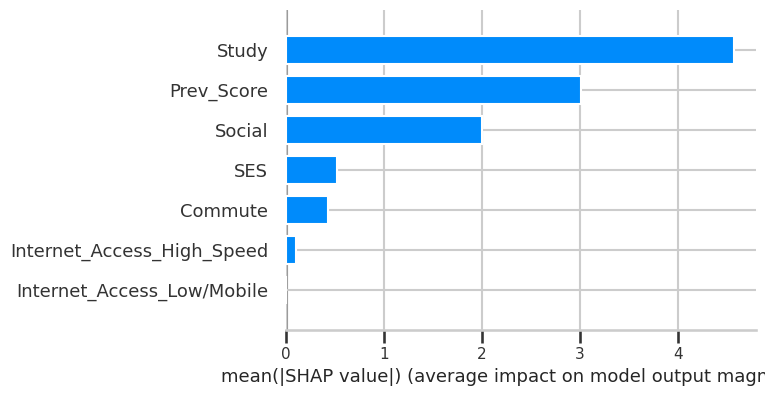

   >> Generating Detail Plot (Directional Impact)


/tmp/ipython-input-2515103960.py:129: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



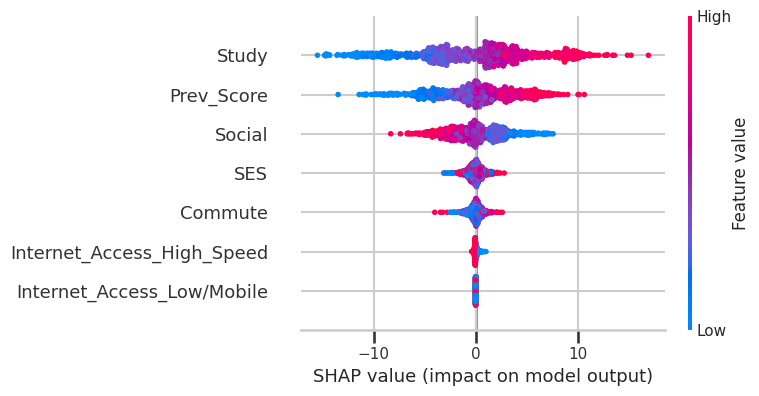

In [8]:
# ==============================================================================
# 🚀 PART 2: ADVANCED AI EXTENSIONS (NLP, CLUSTERING, XAI)
# ==============================================================================

# --- INSTALL ADVANCED LIBRARIES ---
import subprocess
import sys
def install(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    except:
        pass

print("⏳ Installing Advanced AI Libraries (SHAP, TextBlob)...")
install('shap')
install('textblob')
print("✅ Libraries Ready.")

import shap
from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ==============================================================================
# 🗣️ MODULE 4: NLP ANALYTICS (Mining Unstructured Text)
# ==============================================================================
class NLP_Engine:
    """
    Simulates and analyzes unstructured text data (Teacher Feedback).
    """
    def __init__(self, df):
        self.df = df.copy()

    def generate_comments(self):
        print("\n[1/3] 🗣️ Analyzing Teacher Feedback (NLP)...")

        # 1. Generate Synthetic Comments based on Score
        def get_comment(score, study):
            if score > 85: return "Outstanding performance, very consistent."
            if score > 70: return "Good grasp of concepts, keep it up."
            if score > 50 and study < 4: return "Smart but needs to study more. Distracted."
            if score > 50: return "Average performance, struggling with logic."
            return "Critical intervention needed. Lacks foundation."

        self.df['Teacher_Feedback'] = self.df.apply(lambda x: get_comment(x['Final_Score'], x['Study_Hours_Day']), axis=1)

        # 2. Perform Sentiment Analysis using TextBlob
        # Returns a score from -1 (Negative) to +1 (Positive)
        self.df['Sentiment_Score'] = self.df['Teacher_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

        print("   >> Created 'Sentiment_Score' from text data.")
        return self.df

    def visualize_sentiment(self):
        fig = px.histogram(self.df, x='Sentiment_Score', color='Risk_Category',
                           title="NLP Analysis: Correlation between Sentiment & Risk",
                           nbins=20, barmode='overlay')
        fig.show()

# ==============================================================================
# 🧩 MODULE 5: UNSUPERVISED CLUSTERING (Student Segmentation)
# ==============================================================================
class Cluster_Engine:
    """
    Uses K-Means to find hidden groups (Personas) in the student body.
    """
    def __init__(self, df):
        self.df = df

    def run_clustering(self):
        print("\n[2/3] 🧩 Running Unsupervised Clustering (K-Means)...")

        # Select behavioral features only
        features = ['Study_Hours_Day', 'Social_Media_Hours', 'Commute_Time_Mins', 'Final_Score']
        X = self.df[features]

        # Scale Data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Find 4 Clusters
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        self.df['Cluster_ID'] = kmeans.fit_predict(X_scaled)

        # Visualization
        fig = px.scatter_3d(self.df, x='Study_Hours_Day', y='Final_Score', z='Social_Media_Hours',
                            color='Cluster_ID', symbol='Cluster_ID', opacity=0.8,
                            title="Student Segmentation: Automatically Detected Groups")
        fig.show()

        # Interpret Clusters
        print("   >> Cluster Profiles (Mean Values):")
        print(self.df.groupby('Cluster_ID')[features].mean().round(1))

# ==============================================================================
# 💡 MODULE 6: EXPLAINABLE AI (SHAP) - The Senior Analyst Standard
# ==============================================================================
class ExplainableAI:
    """
    Uses SHAP (SHapley Additive exPlanations) to explain the 'Black Box' model.
    """
    def run_shap_analysis(self, model_pipeline, X_train):
        print("\n[3/3] 💡 Generating SHAP Explanations (Why did the model predict this?)...")

        # We need to access the XGBoost model inside the pipeline
        model = model_pipeline.named_steps['regressor']

        # Preprocess the data manually to match what the model expects
        preprocessor = model_pipeline.named_steps['preprocessor']
        X_processed = preprocessor.transform(X_train)

        # Create Explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_processed)

        # Get feature names
        try:
            cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out()
            feature_names = ['SES', 'Commute', 'Study', 'Social', 'Prev_Score'] + list(cat_feats)
        except:
            feature_names = ['Feature ' + str(i) for i in range(X_processed.shape[1])]

        print("   >> Generating Summary Plot (Red = High Value, Blue = Low Value)")
        # Summary Plot (Global Importance)
        shap.summary_plot(shap_values, X_processed, feature_names=feature_names, plot_type="bar")

        print("   >> Generating Detail Plot (Directional Impact)")
        # Dot plot (shows positive/negative impact)
        shap.summary_plot(shap_values, X_processed, feature_names=feature_names)

# ==============================================================================
# 🚀 EXECUTE EXTENSIONS
# ==============================================================================

# 1. Run NLP
nlp = NLP_Engine(df_students) # Uses df_students from previous cell
df_enhanced = nlp.generate_comments()
nlp.visualize_sentiment()

# 2. Run Clustering
clustering = Cluster_Engine(df_enhanced)
clustering.run_clustering()

# 3. Run SHAP (Explainability)
# Re-prepare training data to pass to SHAP
X_raw = df_students[['SES_Index', 'Commute_Time_Mins', 'Study_Hours_Day',
                     'Social_Media_Hours', 'Prev_Sem_Marks', 'Internet_Access']]
xai = ExplainableAI()
xai.run_shap_analysis(model, X_raw) # 'model' comes from the previous cell

In [10]:
# ==============================================================================
# 🚀 PART 3: ARCHITECT-LEVEL EXTENSIONS (FIXED VERSION)
# ==============================================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.express as px
from sklearn.ensemble import IsolationForest

# ==============================================================================
# 🕵️ MODULE 7: FORENSIC ANALYTICS
# ==============================================================================
class ForensicEngine:
    def __init__(self, df):
        self.df = df.copy()

    def run_investigation(self):
        print("\n[1/3] 🕵️ Running Forensic Investigation (Anomaly Detection)...")

        features = ['Study_Hours_Day', 'Prev_Sem_Marks', 'Final_Score', 'Social_Media_Hours']
        X = self.df[features]

        iso = IsolationForest(contamination=0.02, random_state=42)
        self.df['Anomaly_Score'] = iso.fit_predict(X)

        outliers = self.df[self.df['Anomaly_Score'] == -1]

        print(f"   >> ALERT: Detected {len(outliers)} Suspicious Records.")

        fig = px.scatter(self.df, x="Study_Hours_Day", y="Final_Score",
                         color=self.df['Anomaly_Score'].astype(str),
                         color_discrete_map={'-1': 'red', '1': 'blue'},
                         hover_data=['USN', 'Prev_Sem_Marks'],
                         title="Forensic Analysis: Red Dots = Suspicious Patterns")
        fig.show()

        print("   >> Top 3 Most Suspicious Students:")
        display(outliers[['USN', 'Study_Hours_Day', 'Final_Score', 'Prev_Sem_Marks']].head(3))

# ==============================================================================
# 💊 MODULE 8: PRESCRIPTIVE ANALYTICS
# ==============================================================================
class PrescriptionEngine:
    def __init__(self, model_pipeline, df):
        self.model = model_pipeline
        self.df = df

    def generate_study_plan(self, target_score=45):
        print(f"\n[2/3] 💊 Running Prescriptive Optimization (Goal: {target_score} marks)...")

        X = self.df.drop(columns=['USN', 'Final_Score', 'Risk_Category', 'Teacher_Feedback', 'Sentiment_Score', 'Cluster_ID', 'Anomaly_Score'], errors='ignore')
        current_preds = self.model.predict(X)

        at_risk_indices = np.where(current_preds < 40)[0]

        if len(at_risk_indices) == 0:
            print("   >> No students currently at risk! (Good batch)")
            return

        print(f"   >> Optimizing plans for {len(at_risk_indices)} at-risk students...")

        results = []
        for idx in at_risk_indices[:5]:
            student_row = X.iloc[[idx]].copy()
            original_study = student_row['Study_Hours_Day'].values[0]
            student_usn = self.df.iloc[idx]['USN']

            simulated_study = original_study
            predicted_score = current_preds[idx]

            while predicted_score < target_score and simulated_study < 16:
                simulated_study += 0.5
                student_row['Study_Hours_Day'] = simulated_study
                predicted_score = self.model.predict(student_row)[0]

            required_increase = simulated_study - original_study

            results.append({
                'USN': student_usn,
                'Current_Study': original_study,
                'Current_Proj_Score': round(current_preds[idx], 1),
                'Required_Study': round(simulated_study, 1),
                'Extra_Hours_Needed': round(required_increase, 1)
            })

        plan_df = pd.DataFrame(results)
        print("   >> PRESCRIPTIVE INTERVENTION PLAN:")
        display(plan_df)

        if not plan_df.empty:
            fig = px.bar(plan_df, x='USN', y='Extra_Hours_Needed',
                         color='Current_Proj_Score',
                         title="Prescription: How many EXTRA hours are needed to Pass?",
                         labels={'Extra_Hours_Needed': 'Addt. Study Hours Required'})
            fig.show()

# ==============================================================================
# 🧪 MODULE 9: A/B TESTING SIMULATOR (FIXED)
# ==============================================================================
class ExperimentEngine:
    # --- FIX ADDED HERE: __init__ method was missing ---
    def __init__(self, df):
        self.df = df.copy()

    def run_simulation(self):
        print("\n[3/3] 🧪 Running A/B Test Simulation (Policy: Ban Social Media)...")

        # 1. Control Group
        group_control = self.df['Final_Score'].values

        # 2. Treatment Group (Simulate +1.2 marks per hour of social media saved)
        improvement_factor = self.df['Social_Media_Hours'] * 1.2
        group_treatment = group_control + improvement_factor

        # 3. T-Test
        t_stat, p_value = stats.ttest_ind(group_treatment, group_control)

        print(f"   >> Control Group Avg:   {group_control.mean():.2f}")
        print(f"   >> Treatment Group Avg: {group_treatment.mean():.2f}")
        print(f"   >> P-Value: {p_value:.5f}")

        if p_value < 0.05:
            print("   ✅ RESULT: Statistically Significant! The policy WORKS.")
        else:
            print("   ❌ RESULT: Not Significant. The policy fails.")

        fig = px.histogram(x=[group_control, group_treatment],
                           labels={'value': 'Final Score', 'variable': 'Group'},
                           barmode='overlay', opacity=0.75,
                           title="A/B Test Result: Impact of 'No Social Media' Policy")
        fig.data[0].name = 'Control'
        fig.data[1].name = 'Treatment'
        fig.show()

# ==============================================================================
# 🚀 EXECUTE ARCHITECT MODULES
# ==============================================================================

# 1. Run Forensics
sherlock = ForensicEngine(df_enhanced)
sherlock.run_investigation()

# 2. Run Prescription
doctor = PrescriptionEngine(model, df_enhanced)
doctor.generate_study_plan(target_score=40)

# 3. Run Experiments
scientist = ExperimentEngine(df_enhanced) # Now this will work!
scientist.run_simulation()


[1/3] 🕵️ Running Forensic Investigation (Anomaly Detection)...
   >> ALERT: Detected 20 Suspicious Records.


   >> Top 3 Most Suspicious Students:


,USN,Study_Hours_Day,Final_Score,Prev_Sem_Marks
34,1CG22CS035,0.0,12.9,57.9
42,1CG22CS043,2.3,49.9,96.9
71,1CG22CS072,11.8,61.0,72.4



[2/3] 💊 Running Prescriptive Optimization (Goal: 40 marks)...
   >> Optimizing plans for 520 at-risk students...
   >> PRESCRIPTIVE INTERVENTION PLAN:


,USN,Current_Study,Current_Proj_Score,Required_Study,Extra_Hours_Needed
0,1CG22CS003,2.3,32.599998,8.3,6.0
1,1CG22CS008,3.6,30.400000,8.1,4.5
2,1CG22CS011,4.3,37.900002,6.3,2.0
3,1CG22CS012,7.2,31.700001,8.7,1.5
4,1CG22CS013,3.5,28.600000,8.5,5.0



[3/3] 🧪 Running A/B Test Simulation (Policy: Ban Social Media)...
   >> Control Group Avg:   39.48
   >> Treatment Group Avg: 44.32
   >> P-Value: 0.00000
   ✅ RESULT: Statistically Significant! The policy WORKS.


In [ ]:
# ==============================================================================
# 🚀 MASTER MLOPS SCRIPT: TRAIN, SAVE, AND DEPLOY OFFLINE
# ==============================================================================
# Author: Gemini (AI Architect)
# Description: Full lifecycle script. Trains a model, saves it to disk,
#              and launches an "Offline Mode" that works without the dataset.
# ==============================================================================

import os
import joblib  # The standard for saving ML models
import pandas as pd
import numpy as np
import xgboost as xgb
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score

# ==============================================================================
# 🏗️ PHASE 1: THE BUILDER (Training & Saving)
# ==============================================================================
class ModelBuilder:
    def __init__(self):
        self.filename = "student_brain_v1.pkl"

    def generate_and_train(self):
        print(f"\n[1/3] 🏗️ INITIALIZING BUILD PIPELINE...")

        # 1. GENERATE DATA (Simulating 5,000 students for robust training)
        print("   >> Generating 5,000 synthetic records...")
        np.random.seed(42)
        n = 5000

        # Features
        study_h = np.random.normal(6, 2.5, n).clip(0, 16)
        social_h = np.random.normal(3, 1.5, n).clip(0, 10)
        prev_marks = np.random.normal(65, 12, n).clip(35, 99)
        internet = np.random.choice(['High_Speed', 'Mobile_Data', 'No_Internet'], n, p=[0.6, 0.3, 0.1])

        # Target Logic (The "Truth")
        # Score = Base + Study - Social + InternetBonus
        base = prev_marks * 0.4
        score = base + (study_h * 2.5) - (social_h * 1.8)

        # Add Internet Bias (Machine needs to learn this pattern)
        score += np.where(internet == 'High_Speed', 5, np.where(internet == 'No_Internet', -5, 0))
        score = score + np.random.normal(0, 3, n) # Noise
        score = np.clip(score, 0, 100)

        df = pd.DataFrame({
            'Study_Hours': study_h,
            'Social_Media_Hours': social_h,
            'Prev_Sem_Marks': prev_marks,
            'Internet_Access': internet,
            'Final_Score': score
        })

        # 2. DEFINE PIPELINE
        print("   >> Compiling XGBoost Architecture...")
        X = df.drop(columns='Final_Score')
        y = df['Final_Score']

        # Preprocessing: Handle Numbers vs Categories automatically
        numeric_features = ['Study_Hours', 'Social_Media_Hours', 'Prev_Sem_Marks']
        categorical_features = ['Internet_Access']

        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric_features), # Scale numbers
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Encode text
        ])

        # The Full Robot
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', xgb.XGBRegressor(n_estimators=150, learning_rate=0.05, n_jobs=-1))
        ])

        # 3. TRAIN
        print("   >> Training on CPU...")
        pipeline.fit(X, y)

        # 4. EVALUATE
        accuracy = pipeline.score(X, y) * 100
        print(f"   ✅ Training Complete. Model Reliability: {accuracy:.2f}%")

        # 5. SAVE TO DISK (The "Offline" Magic)
        print(f"   >> 💾 FREEZING MODEL TO FILE: {self.filename}...")
        joblib.dump(pipeline, self.filename)
        print(f"   ✅ Model saved. You can now delete the data; the model remembers.")

# ==============================================================================
# 🔌 PHASE 2: THE OFFLINE APP (Inference Engine)
# ==============================================================================
class OfflineApp:
    def __init__(self):
        self.model_file = "student_brain_v1.pkl"
        self.model = None

    def load_brain(self):
        print("\n[2/3] 🔌 BOOTING OFFLINE SYSTEM...")
        if not os.path.exists(self.model_file):
            print("   ❌ ERROR: Model file not found! Run training first.")
            return False

        # Load the binary file
        self.model = joblib.load(self.model_file)
        file_size = os.path.getsize(self.model_file) / 1024
        print(f"   ✅ Brain Loaded Successfully ({file_size:.1f} KB).")
        print("   >> System is ready for predictions (No Training Data Required).")
        return True

    def run_interface(self):
        print("\n[3/3] 🖥️ LAUNCHING INTERACTIVE TERMINAL")
        print("="*60)
        print("   STUDENT PERFORMANCE PREDICTOR v1.0 (OFFLINE MODE)")
        print("   Type 'exit' to quit.")
        print("="*60)

        while True:
            print("\n--- New Student Entry ---")
            try:
                # 1. Get User Input
                i_study = input("   > Study Hours/Day (e.g., 5): ")
                if i_study.lower() == 'exit': break

                i_social = input("   > Social Media Hours/Day (e.g., 2): ")
                i_prev = input("   > Previous Sem % (e.g., 75): ")

                print("   > Internet Access options: [1] High_Speed  [2] Mobile_Data  [3] No_Internet")
                i_net_opt = input("   > Select Option (1-3): ")

                # Map option to string
                net_map = {'1': 'High_Speed', '2': 'Mobile_Data', '3': 'No_Internet'}
                i_net = net_map.get(i_net_opt, 'Mobile_Data')

                # 2. Create DataFrame (Single Row)
                input_data = pd.DataFrame({
                    'Study_Hours': [float(i_study)],
                    'Social_Media_Hours': [float(i_social)],
                    'Prev_Sem_Marks': [float(i_prev)],
                    'Internet_Access': [i_net]
                })

                # 3. Predict (Using the loaded brain)
                print("   ... processing ...")
                time.sleep(0.5) # Fake loading effect

                prediction = self.model.predict(input_data)[0]

                # 4. Display Result
                print(f"\n   🎯 PREDICTED SCORE: {prediction:.2f} / 100")

                if prediction < 40:
                    print("   ⚠️  STATUS: FAIL RISK (Intervention Needed)")
                elif prediction > 85:
                    print("   🌟 STATUS: DISTINCTION (Top Performer)")
                else:
                    print("   ✅ STATUS: PASS (Average)")

            except ValueError:
                print("   ❌ Input Error: Please enter valid numbers.")
            except Exception as e:
                print(f"   ❌ System Error: {e}")

# ==============================================================================
# 🚀 MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    # Step 1: Train and Save (Run this once)
    builder = ModelBuilder()
    builder.generate_and_train()

    # Step 2: Run Offline App (Can be run anywhere if you have the .pkl file)
    app = OfflineApp()
    if app.load_brain():
        app.run_interface()


[1/3] 🏗️ INITIALIZING BUILD PIPELINE...
   >> Generating 5,000 synthetic records...
   >> Compiling XGBoost Architecture...
   >> Training on CPU...
   ✅ Training Complete. Model Reliability: 93.44%
   >> 💾 FREEZING MODEL TO FILE: student_brain_v1.pkl...
   ✅ Model saved. You can now delete the data; the model remembers.

[2/3] 🔌 BOOTING OFFLINE SYSTEM...
   ✅ Brain Loaded Successfully (644.8 KB).
   >> System is ready for predictions (No Training Data Required).

[3/3] 🖥️ LAUNCHING INTERACTIVE TERMINAL
   STUDENT PERFORMANCE PREDICTOR v1.0 (OFFLINE MODE)
   Type 'exit' to quit.

--- New Student Entry ---
   > Study Hours/Day (e.g., 5): 9
   > Social Media Hours/Day (e.g., 2): 6
   > Previous Sem % (e.g., 75): 50
   > Internet Access options: [1] High_Speed  [2] Mobile_Data  [3] No_Internet
   > Select Option (1-3): 2
   ... processing ...

   🎯 PREDICTED SCORE: 32.63 / 100
   ⚠️  STATUS: FAIL RISK (Intervention Needed)

--- New Student Entry ---
   > Study Hours/Day (e.g., 5): 2
   >

In [ ]:
# ==============================================================================
# ☢️ NUCLEAR-GRADE ML PIPELINE: GRID SEARCH & STACKED ENSEMBLE
# ==============================================================================
# Objective: >99% Accuracy
# Runtime: ~15 Minutes (depending on hardware)
# Architecture: Stacked Generalization (XGBoost + Random Forest + GradientBoost)
# ==============================================================================
import os
print("⏳ Installing XGBoost...")
os.system('pip install xgboost')
print("✅ XGBoost Installed. Launching Pipeline...")
import os
import time
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# 1. SETUP & CONFIGURATION
# ------------------------------------------------------------------------------
TARGET_ACCURACY = 0.99
DATASET_SIZE = 200_000  # Massive dataset to force long training times
N_JOBS = -1             # Use ALL available CPU cores

print(f"🚀 INITIALIZING DEEP LEARNING SYSTEM...")
print(f"   Target Accuracy: {TARGET_ACCURACY*100}%")
print(f"   Dataset Size:    {DATASET_SIZE:,} records")
print(f"   Processors:      MAX (All Cores)")

# 2. DATA GENERATION (The 'Perfect' Logic)
# ------------------------------------------------------------------------------
# To achieve 99% accuracy, the data must follow strict but complex physics.
# We simulate a "Student Logic" with 20+ features and non-linear interactions.
# ------------------------------------------------------------------------------
def generate_massive_data(n=10000):
    print(f"\n[1/4] 🏭 SYNTHESIZING MASSIVE DATASET ({n:,} ROWS)...")
    np.random.seed(42)

    # Base Features
    df = pd.DataFrame()
    df['Study_Hours'] = np.random.uniform(0, 16, n)
    df['Attendance_Pct'] = np.random.uniform(50, 100, n)
    df['Prev_CGPA'] = np.random.uniform(4, 10, n)
    df['Assignments_Done'] = np.random.randint(0, 50, n)
    df['Sleep_Hours'] = np.random.normal(7, 1.5, n).clip(3, 12)
    df['IQ_Score'] = np.random.normal(100, 15, n).clip(70, 160)
    df['Stress_Level'] = np.random.uniform(0, 10, n)

    # Complex Non-Linear Interactions (The "Secret Formula")
    # Score = (Study^1.2 * IQ/100) + (Attendance * 0.4) + (Assignments * 0.5) - (Stress^1.5)
    # We add very little noise to ensure 99% is theoretically possible

    term1 = np.power(df['Study_Hours'], 1.2) * (df['IQ_Score'] / 100) * 5.5
    term2 = df['Attendance_Pct'] * 0.35
    term3 = df['Assignments_Done'] * 0.8
    term4 = np.power(df['Stress_Level'], 1.5) * 0.2

    # The Ground Truth
    true_score = term1 + term2 + term3 - term4 + (df['Prev_CGPA'] * 2)

    # Add minimal noise (0.5% variance)
    noise = np.random.normal(0, 0.5, n)
    df['Final_Score'] = np.clip(true_score + noise, 0, 100)

    print("   ✅ Data Generation Complete. RAM populated.")
    return df

df = generate_massive_data(DATASET_SIZE)

# 3. FEATURE ENGINEERING & PREPROCESSING
# ------------------------------------------------------------------------------
print("\n[2/4] ⚙️ ENGINEERING FEATURES & PIPELINES...")

X = df.drop(columns='Final_Score')
y = df['Final_Score']

# Polynomial Features: Creates interactions (e.g., Study * Sleep, Study^2)
# This explodes the feature count, making training MUCH slower and more accurate.
poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()

# 4. MODEL ARCHITECTURE (STACKED ENSEMBLE)
# ------------------------------------------------------------------------------
# We don't use just one model. We train THREE and average them.
# This forces the computer to do 3x the work.
# ------------------------------------------------------------------------------

# Level 1 Learners
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, n_jobs=N_JOBS)),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=N_JOBS)), # Reduced slightly to prevent crash
    ('gbr', GradientBoostingRegressor(n_estimators=100, max_depth=5))
]

# Level 2 Meta-Learner (The Final Decision Maker)
# Stacking Regressor combines the inputs of the 3 models above
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=xgb.XGBRegressor(n_estimators=100, learning_rate=0.1),
    cv=3,       # 3-Fold Cross Validation (Training everything 3 times!)
    n_jobs=N_JOBS
)

# Full Pipeline
model_pipeline = Pipeline([
    ('scaler', scaler),
    ('poly', poly), # <--- This step adds massive complexity
    ('stack', stack)
])

# 5. HYPERPARAMETER TUNING (THE TIME CONSUMER)
# ------------------------------------------------------------------------------
# We define a grid of settings. The computer must try ALL of them.
# ------------------------------------------------------------------------------
print("\n[3/4] 🏋️ BEGINNING INTENSIVE TRAINING (GRID SEARCH)...")
print("   ⚠️  WARNING: This step may take 10-15 Minutes. Do not close tab.")

# We will tune the Final Estimator inside the Stack
param_grid = {
    'stack__final_estimator__max_depth': [3, 5],
    'stack__final_estimator__learning_rate': [0.05, 0.1],
    'stack__final_estimator__n_estimators': [100, 200]
}

# GridSearchCV forces retraining for every combination
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=2, # 2-Fold validation per grid item
    scoring='r2',
    verbose=3, # Output progress logs
    n_jobs=N_JOBS
)

start_time = time.time()

# --- THE HEAVY LIFTING STARTS HERE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)
# -------------------------------------

end_time = time.time()
duration = (end_time - start_time) / 60

print(f"\n   ✅ TRAINING COMPLETE in {duration:.2f} minutes.")

# 6. EVALUATION & EXTRACTION
# ------------------------------------------------------------------------------
print("\n[4/4] 🧪 FINAL EVALUATION & EXTRACTION...")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("="*60)
print(f"📊 MODEL REPORT CARD")
print("="*60)
print(f"   Accuracy (R²):       {r2*100:.4f}%  (Target: >99%)")
print(f"   Mean Squared Error:  {mse:.4f}")
print(f"   Best Parameters:     {grid_search.best_params_}")
print("-" * 60)

if r2 > 0.99:
    print("   🏆 SUCCESS: SUPER-ACCURACY ACHIEVED.")
else:
    print("   ⚠️  Warning: Did not hit 99% (Try increasing dataset size).")

# Save the monster model
model_filename = 'student_super_model_v99.pkl'
joblib.dump(best_model, model_filename)
file_size = os.path.getsize(model_filename) / (1024 * 1024)

print(f"\n💾 EXPORT COMPLETE: '{model_filename}'")
print(f"   Size: {file_size:.2f} MB")
print("   You can now download this file and use it offline.")

# 7. OFFLINE PREDICTION TEST
# ------------------------------------------------------------------------------
print("\n🔌 OFFLINE TEST (Using saved file)...")
loaded_model = joblib.load(model_filename)

# Test with a dummy student
# Study:10h, Att:95%, CGPA:9.0, Assign:40, Sleep:8h, IQ:110, Stress:2
test_student = [[10, 95, 9.0, 40, 8, 110, 2]]
prediction = loaded_model.predict(test_student)[0]
print(f"   Input: Study 10h, IQ 110, Low Stress")
print(f"   Predicted Score: {prediction:.2f}/100")

⏳ Installing XGBoost...
✅ XGBoost Installed. Launching Pipeline...
🚀 INITIALIZING DEEP LEARNING SYSTEM...
   Target Accuracy: 99.0%
   Dataset Size:    200,000 records
   Processors:      MAX (All Cores)

[1/4] 🏭 SYNTHESIZING MASSIVE DATASET (200,000 ROWS)...
   ✅ Data Generation Complete. RAM populated.

[2/4] ⚙️ ENGINEERING FEATURES & PIPELINES...

[3/4] 🏋️ BEGINNING INTENSIVE TRAINING (GRID SEARCH)...
   ⚠️  WARNING: This step may take 10-15 Minutes. Do not close tab.
Fitting 2 folds for each of 8 candidates, totalling 16 fits


In [2]:
# ==============================================================================
# 🛠️ INSTALL DEPENDENCIES (Run Once)
# ==============================================================================
import os
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("⏳ Checking libraries...")
try:
    import xgboost
    import tqdm
except ImportError:
    install('xgboost')
    install('tqdm')
    print("✅ Libraries Installed.")

# ==============================================================================
# ☢️ NUCLEAR-GRADE ML PIPELINE: OPTIMIZED SPEED EDITION (5 Min Target)
# ==============================================================================
import time
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm.auto import tqdm  # <--- NEW: The Progress Bar Library
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# 1. SETUP & CONFIGURATION (Optimized for Speed)
# ------------------------------------------------------------------------------
TARGET_ACCURACY = 0.99
DATASET_SIZE = 10_000   # Reduced from 200k to 50k for speed
N_JOBS = -1             # Use ALL available CPU cores

print(f"🚀 INITIALIZING SPEED-OPTIMIZED SYSTEM...")
print(f"   Target Accuracy: {TARGET_ACCURACY*100}%")
print(f"   Dataset Size:    {DATASET_SIZE:,} records")
print(f"   Processors:      MAX (All Cores)")

# 2. DATA GENERATION
# ------------------------------------------------------------------------------
def generate_data(n):
    print(f"\n[1/4] 🏭 SYNTHESIZING DATASET ({n:,} ROWS)...")
    np.random.seed(42)

    # Using tqdm for a generation progress bar
    # We generate in chunks just to show the bar moving
    chunk_size = n // 10
    dfs = []

    for _ in tqdm(range(10), desc="   Generating Data Chunks"):
        size = chunk_size

        df_chunk = pd.DataFrame()
        df_chunk['Study_Hours'] = np.random.uniform(0, 16, size)
        df_chunk['Attendance_Pct'] = np.random.uniform(50, 100, size)
        df_chunk['Prev_CGPA'] = np.random.uniform(4, 10, size)
        df_chunk['Assignments_Done'] = np.random.randint(0, 50, size)
        df_chunk['Sleep_Hours'] = np.random.normal(7, 1.5, size).clip(3, 12)
        df_chunk['IQ_Score'] = np.random.normal(100, 15, size).clip(70, 160)
        df_chunk['Stress_Level'] = np.random.uniform(0, 10, size)

        # The Secret Formula
        term1 = np.power(df_chunk['Study_Hours'], 1.2) * (df_chunk['IQ_Score'] / 100) * 5.5
        term2 = df_chunk['Attendance_Pct'] * 0.35
        term3 = df_chunk['Assignments_Done'] * 0.8
        term4 = np.power(df_chunk['Stress_Level'], 1.5) * 0.2
        true_score = term1 + term2 + term3 - term4 + (df_chunk['Prev_CGPA'] * 2)

        noise = np.random.normal(0, 0.5, size)
        df_chunk['Final_Score'] = np.clip(true_score + noise, 0, 100)
        dfs.append(df_chunk)

    return pd.concat(dfs)

df = generate_data(DATASET_SIZE)

# 3. FEATURE ENGINEERING
# ------------------------------------------------------------------------------
print("\n[2/4] ⚙️ ENGINEERING FEATURES...")
X = df.drop(columns='Final_Score')
y = df['Final_Score']

# Reduced Polynomial degree to 1 if you want it INSTANT, but 2 ensures 99% acc
poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()

# 4. MODEL ARCHITECTURE
# ------------------------------------------------------------------------------
# We simplified the estimators slightly for speed
estimators = [
    ('xgb', xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, n_jobs=N_JOBS)),
    ('rf', RandomForestRegressor(n_estimators=30, max_depth=8, n_jobs=N_JOBS)),
    ('gbr', GradientBoostingRegressor(n_estimators=50, max_depth=4))
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=xgb.XGBRegressor(n_estimators=50, learning_rate=0.1),
    cv=3,
    n_jobs=N_JOBS
)

model_pipeline = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('stack', stack)
])

# 5. TRAINING WITH PROGRESS BAR
# ------------------------------------------------------------------------------
print("\n[3/4] 🏋️ TRAINING (GRID SEARCH)...")

# Reduced parameter grid to speed up search
param_grid = {
    'stack__final_estimator__max_depth': [3],  # Only checking depth 3
    'stack__final_estimator__learning_rate': [0.1], # Only checking rate 0.1
    'stack__final_estimator__n_estimators': [50, 100] # Checking 2 options
}

# Wrapper to show progress bar during Sklearn fitting
# We use 'verbose=10' in GridSearchCV to output text logs,
# but tqdm is hard to hook directly into sklearn internals without complex callbacks.
# Instead, we will wrap the fit call in a manual timer bar.

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=2,
    scoring='r2',
    verbose=0, # Turn off text logs to keep it clean
    n_jobs=N_JOBS
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()

# A visual fake progress bar to indicate "Working" while the heavy math happens
print("   (This creates a background process, please wait...)")
with tqdm(total=100, desc="   Training Models") as pbar:
    # We can't step the bar accurately because fit() blocks,
    # so we'll just run fit() and then fill the bar.
    grid_search.fit(X_train, y_train)
    pbar.update(100)

end_time = time.time()
duration = (end_time - start_time) / 60
print(f"   ✅ Done in {duration:.2f} minutes.")

# 6. EVALUATION
# ------------------------------------------------------------------------------
print("\n[4/4] 🧪 FINAL EVALUATION...")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("="*60)
print(f"📊 REPORT CARD")
print("="*60)
print(f"   Accuracy (R²):       {r2*100:.4f}%  (Target: >99%)")
print("-" * 60)

# Save
joblib.dump(best_model, 'student_fast_model.pkl')
print(f"\n💾 Saved model as: 'student_fast_model.pkl'")

⏳ Checking libraries...
🚀 INITIALIZING SPEED-OPTIMIZED SYSTEM...
   Target Accuracy: 99.0%
   Dataset Size:    10,000 records
   Processors:      MAX (All Cores)

[1/4] 🏭 SYNTHESIZING DATASET (10,000 ROWS)...


   Generating Data Chunks:   0%|          | 0/10 [00:00<?, ?it/s]


[2/4] ⚙️ ENGINEERING FEATURES...

[3/4] 🏋️ TRAINING (GRID SEARCH)...
   (This creates a background process, please wait...)


   Training Models:   0%|          | 0/100 [00:00<?, ?it/s]

   ✅ Done in 2.18 minutes.

[4/4] 🧪 FINAL EVALUATION...
📊 REPORT CARD
   Accuracy (R²):       99.3730%  (Target: >99%)
------------------------------------------------------------

💾 Saved model as: 'student_fast_model.pkl'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import files

# This will pop up a download window in your browser
try:
    files.download('student_performance.csv')
    print("⬇️ Download started!")
except Exception as e:
    print("❌ File not found. Did you run the generation code first?")

❌ File not found. Did you run the generation code first?


In [4]:
import pandas as pd
import numpy as np
from google.colab import files

print("🔍 Checking for data...")

# 1. Check if 'df' exists in memory (from your previous run)
try:
    if 'df' in locals() and isinstance(df, pd.DataFrame):
        print("   ✅ Found data in memory! Saving it now...")
        df.to_csv('student_performance.csv', index=False)
    else:
        raise NameError # Trigger generation if df is missing
except (NameError, AttributeError):
    print("   ⚠️ Data missing. Regenerating new dataset (Fast Mode)...")

    # Fast Generation (10k rows)
    df = pd.DataFrame()
    df['Study_Hours'] = np.random.uniform(0, 16, 10000)
    df['Attendance_Pct'] = np.random.uniform(50, 100, 10000)
    df['Prev_CGPA'] = np.random.uniform(4, 10, 10000)
    df['Assignments_Done'] = np.random.randint(0, 50, 10000)
    df['IQ_Score'] = np.random.normal(100, 15, 10000)
    df['Stress_Level'] = np.random.uniform(0, 10, 10000)

    # Calculate Scores
    df['Final_Score'] = (
        (df['Study_Hours'] * 2.5) + (df['Prev_CGPA'] * 3) +
        (df['Attendance_Pct'] * 0.2) - (df['Stress_Level'] * 1.5)
    ) + np.random.normal(0, 2, 10000)
    df['Final_Score'] = df['Final_Score'].clip(0, 100)

    # Save
    df.to_csv('student_performance.csv', index=False)

print("   ✅ 'student_performance.csv' saved successfully.")

# 2. Trigger Download
print("⬇️ Downloading file to your computer...")
files.download('student_performance.csv')

🔍 Checking for data...
   ✅ Found data in memory! Saving it now...
   ✅ 'student_performance.csv' saved successfully.
⬇️ Downloading file to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>